# Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score
)
from sklearn.calibration import calibration_curve
from venn_abers import VennAbersCalibrator
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import log_loss

from sklearn.isotonic import IsotonicRegression



# Helper Functions

In [50]:
def calib_metrics(y, p, name):
    prob_true, prob_pred = calibration_curve(y, p, n_bins=10)
    ece = np.abs(prob_true - prob_pred).mean()
    return {
        "Method": name,
        "LogLoss": log_loss(y, p),
        "Brier": brier_score_loss(y, p),
        "ROC_AUC": roc_auc_score(y, p),
        "ECE": ece
    }

def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return float(np.mean(np.abs(pt - pp))), pt, pp


# Data Simulation

In [40]:
rng = np.random.default_rng(42)
counts = {0: 25473, 1: 7108}

# Class 0: Beta(2,8) + Gaussian noise
probs_0 = rng.beta(2, 8, size=counts[0]) + rng.normal(0, 0.05, size=counts[0])
probs_0 = np.clip(probs_0, 0, 1)

# Class 1: Beta(8,2) + Gaussian noise
probs_1 = rng.beta(8, 2, size=counts[1]) + rng.normal(0, 0.05, size=counts[1])
probs_1 = np.clip(probs_1, 0, 1)

df_sim = pd.DataFrame({
    "y": np.concatenate([np.zeros(counts[0], int), np.ones(counts[1], int)]),
    "proba": np.concatenate([probs_0, probs_1])
}).sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sim.groupby("y")["proba"].describe())

     count     mean       std       min       25%       50%       75%  \
y                                                                       
0  25473.0  0.20048  0.129171  0.000000  0.104316  0.182588  0.278576   
1   7108.0  0.80071  0.129760  0.207424  0.721096  0.818251  0.898573   

        max  
y            
0  0.848151  
1  1.000000  


# Distribution Visualization

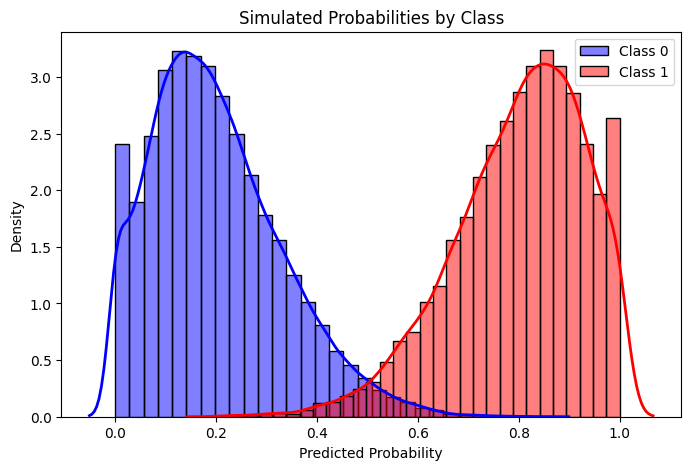

In [41]:
plt.figure(figsize=(8,5))
sns.histplot(df_sim[df_sim["y"]==0]["proba"], bins=30, color="blue", label="Class 0", stat="density", alpha=0.5)
sns.histplot(df_sim[df_sim["y"]==1]["proba"], bins=30, color="red", label="Class 1", stat="density", alpha=0.5)

sns.kdeplot(df_sim[df_sim["y"]==0]["proba"], color="blue", lw=2)
sns.kdeplot(df_sim[df_sim["y"]==1]["proba"], color="red", lw=2)

plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.title("Simulated Probabilities by Class")
plt.legend()
plt.show()


# Splitting the Data

In [ ]:
y_sim = df_sim["y"].values
p_raw = df_sim["proba"].values
X_cal, X_test, y_cal, y_test = train_test_split(
    df_sim[["proba"]].values, df_sim["y"].values,
    test_size=0.3, stratify=df_sim["y"].values, random_state=42
)

s_cal  = X_cal.ravel()
s_test = X_test.ravel()

# Platt Scaling

In [45]:
p_platt_test, platt_params_test = platt_fit_predict(s_cal, y_cal, s_test)
p_platt_cal, platt_params_cal = platt_fit_predict(s_cal, y_cal, s_cal)

# Isotonic Regression

In [46]:
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(s_cal, y_cal)

p_iso_test = iso.predict(s_test)
p_iso_cal = iso.predict(s_cal)

# Venn Abbers Calibration

In [47]:
p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
p_test_2d = np.column_stack([1 - s_test, s_test])

va = VennAbersCalibrator()
p_va_point = va.predict_proba(
    p_cal=p_cal_2d, y_cal=y_cal,
    p_test=p_test_2d, p0_p1_output=False
)
p_va = p_va_point[:, 1] 

In [48]:
va = VennAbersCalibrator()
p_va_point_cal = va.predict_proba(
    p_cal=p_cal_2d, y_cal=y_cal,
    p_test=p_cal_2d, p0_p1_output=False
)
p_va_cal = p_va_point_cal[:, 1] 

In [ ]:
p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
p_test_2d = np.column_stack([1 - s_test, s_test])

va = VennAbersCalibrator()
p_va_point_cal = va.predict_proba(
    p_cal=p_cal_2d, y_cal=y_cal,
    p_test=p_cal_2d, p0_p1_output=False
)
p_va_cal = p_va_point_cal[:, 1] 

In [52]:
s_cal

array([0.27852546, 0.29122836, 0.55278642, ..., 0.41379804, 0.15391284,
       0.95149451])

In [49]:
p_cal_2d

array([[0.72147454, 0.27852546],
       [0.70877164, 0.29122836],
       [0.44721358, 0.55278642],
       ...,
       [0.58620196, 0.41379804],
       [0.84608716, 0.15391284],
       [0.04850549, 0.95149451]])

In [33]:
p_va_point

array([[0.00198413, 0.99801587],
       [0.0046729 , 0.9953271 ],
       [0.25806452, 0.74193548],
       ...,
       [0.00906011, 0.99093989],
       [0.99877883, 0.00122117],
       [0.99564922, 0.00435078]])

# Analyze Results

In [51]:
methods_test = {
    "Raw": s_test,
    "Platt": p_platt_test,
    "Isotonic": p_iso_test,
    "Venn-Abers-IVAP": p_va,
}

rows = []
for name, p in methods_test.items():
    ece, _, _ = ece_quantile(y_test, p, n_bins=10)
    rows.append({
        "Method": name,
        "LogLoss": log_loss(y_test, p),
        "Brier": brier_score_loss(y_test, p),
        "ROC_AUC": roc_auc_score(y_test, p),
        "ECE": ece,
    })

calib_df = pd.DataFrame(rows).set_index("Method").round(4)
display(calib_df)



,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3367,0.0927,0.9735,0.2076
Platt,0.1525,0.0425,0.9735,0.0084
Isotonic,0.1507,0.0425,0.9734,0.0040
Venn-Abers-IVAP,0.1508,0.0425,0.9734,0.0042


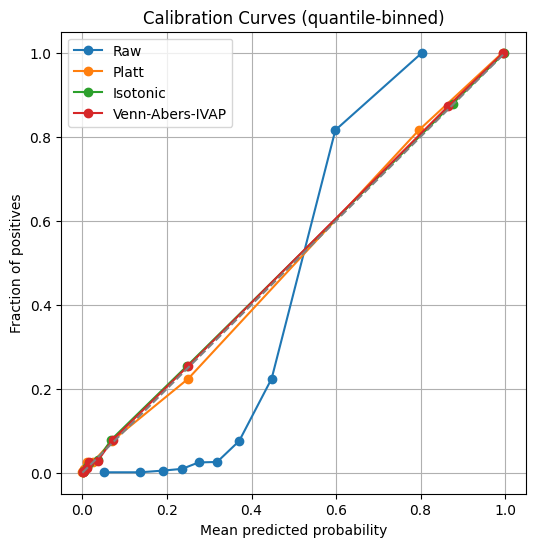

In [53]:
plt.figure(figsize=(6,6))
for name, p in methods_test.items():
    _, pt, pp = ece_quantile(y_test, p, n_bins=10)
    plt.plot(pp, pt, marker='o', label=name)
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves (quantile-binned)")
plt.legend(); plt.grid(True); plt.show()

In [54]:
methods_cal = {
    "Raw": s_cal,
    "Platt": p_platt_cal,
    "Isotonic": p_iso_cal,
    "Venn-Abers-IVAP": p_va_cal,
}

rows = []
for name, p in methods_cal.items():
    ece, _, _ = ece_quantile(y_cal, p, n_bins=10)
    rows.append({
        "Method": name,
        "LogLoss": log_loss(y_cal, p),
        "Brier": brier_score_loss(y_cal, p),
        "ROC_AUC": roc_auc_score(y_cal, p),
        "ECE": ece,
    })

calib_df = pd.DataFrame(rows).set_index("Method").round(4)
display(calib_df)



,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3326,0.0911,0.9768,0.2067
Platt,0.1447,0.0406,0.9768,0.0065
Isotonic,0.1412,0.0400,0.9772,0.0000
Venn-Abers-IVAP,0.1418,0.0401,0.9771,0.0021


In [37]:
def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return float(np.mean(np.abs(pt - pp))), pt, pp

methods = {
    "Raw": s_test,
    "Platt": p_platt,
    "Isotonic": p_iso,
    "Venn-Abers-IVAP": p_va,
}

rows = []
for name, p in methods.items():
    ece, _, _ = ece_quantile(y_test, p, n_bins=10)
    rows.append({
        "Method": name,
        "LogLoss": log_loss(y_test, p),
        "Brier": brier_score_loss(y_test, p),
        "ROC_AUC": roc_auc_score(y_test, p),
        "ECE": ece,
    })

calib_df = pd.DataFrame(rows).set_index("Method").round(4)
display(calib_df)



,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3367,0.0927,0.9735,0.2076
Platt,0.1525,0.0425,0.9735,0.0084
Isotonic,0.1507,0.0425,0.9734,0.0040
Venn-Abers-IVAP,0.1508,0.0425,0.9734,0.0042


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>LogLoss</th>
      <th>Brier</th>
      <th>ROC_AUC</th>
      <th>ECE</th>
    </tr>
    <tr>
      <th>Method</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Raw</th>
      <td>0.3326</td>
      <td>0.0911</td>
      <td>0.9768</td>
      <td>0.2067</td>
    </tr>
    <tr>
      <th>Platt</th>
      <td>0.1447</td>
      <td>0.0406</td>
      <td>0.9768</td>
      <td>0.0065</td>
    </tr>
    <tr>
      <th>Isotonic</th>
      <td>0.1412</td>
      <td>0.0400</td>
      <td>0.9772</td>
      <td>0.0000</td>
    </tr>
    <tr>
      <th>Venn-Abers-IVAP</th>
      <td>0.1418</td>
      <td>0.0401</td>
      <td>0.9771</td>
      <td>0.0021</td>
    </tr>
  </tbody>
</table>
</div>